In [26]:
import numpy as np
import pandas as pd
import Bio
from Bio import PDB
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
import matplotlib.pylab as plt
import matplotlib
import os
from os import listdir
from os.path import isfile, join, isdir
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 12})
rc('text', usetex=True)
import pandas as pd
from sklearn import metrics
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr, kendalltau
import pickle
import re
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
import sklearn.metrics
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
%matplotlib inline

# Some basic functions for the code to run

In [3]:
def create_prob_dist_identical_bins(data, fig, ax, bins = [], n_bins = 100, color = "black", label = None, alpha = 1.0, marker = "o"):
    '''
    plots a probability distribution from the data provided
    '''
    if bins == []:
        bins = np.linspace(min(data),max(data),n_bins)
        bin_range = abs(bins[1]-bins[0])
        bins = np.array([min(bins)-bin_range] + list(bins) + [max(bins) + bin_range])
    
    n, bins, patches = ax.hist(data, bins=bins, density=True, histtype= "step", alpha = 0)
    bins = np.delete(bins, -1)
    bins += abs(bins[1]-bins[0])/2
    
    
    ax.plot(bins, n, marker=marker, color=color, markerfacecolor='none', label = label, alpha = alpha)
    
    x = np.array(bins)
    y = np.array(n)
    
    return x, y

# Load in the supersampled and nonsupersampled main datasets

In [4]:
os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_datasets")

ss_corr_df = pd.read_csv("supersampled_correlation_dataset_final_manuscript.csv")
relaxed_corr_df = pd.read_csv("non_supersampled_correlation_dataset_final_manuscript.csv")

In [5]:
## Load in the supersampled balanced dataset for each target

ss_balanced_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/all_supersampled_balanced_datasets"
os.chdir(ss_balanced_dir)

pdb_list = list(ss_corr_df["pdb"])

all_csv_files = sorted([f for f in listdir(ss_balanced_dir) if isfile(join(ss_balanced_dir, f)) and ".csv" in f and f[:4] in pdb_list])

ss_score_dict = {}
for csv_file in all_csv_files:
    pdb_name = csv_file[:4]
    ss_score_dict[pdb_name] = pd.read_csv(csv_file)

In [6]:
## Load in the pickle data

os.chdir("/Users/jakesumner/Desktop/PPI Project/")

with open("subsampling_400.pickle", "rb") as f:
    subsampling_400 = pickle.load(f)
    
with open("subsampling_200.pickle", "rb") as f:
    subsampling_200 = pickle.load(f)
    
with open("subsampling_100.pickle", "rb") as f:
    subsampling_100 = pickle.load(f)
    
with open("subsampling_50.pickle", "rb") as f:
    subsampling_50 = pickle.load(f)

### Non-supersampled original 500 Zdock run

In [7]:
not_supersampled_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_all_unsupersampled_scores"
os.chdir(not_supersampled_dir)

all_csv_files = sorted([f for f in listdir(not_supersampled_dir) if isfile(join(not_supersampled_dir, f)) and ".csv" in f and f[:4] in pdb_list])

zdock_relaxed_combined_dfs = {}
for csv_file in all_csv_files:
    pdb_name = csv_file[:4]
    zdock_relaxed_combined_dfs[pdb_name] = pd.read_csv(csv_file)

## Load the exhaustive sampling data

In [8]:
exhaustive_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/exhaustive_all_targets"

os.chdir(exhaustive_dir)

exhaustive_corr_df = pd.read_csv("exhaustive_correlation_dataframe.csv")

exhaustive_score_dict = {}

csv_files = glob.glob("*exhaustive_scores.csv")

for pdb_file in csv_files:
    pdb_name = pdb_file[:4]
    temp_df = pd.read_csv(pdb_file)
    
    exhaustive_score_dict[pdb_name] = temp_df


### Target Score Dataframe

In [9]:
os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling")

target_file = "all_89_target_scores.txt"

temp_dict = {
    "pdb" : [],
    "ZRank" : [],
    "HDOCK" : [],
    "Rosetta" : [],
    "PyDock" : [],
    "VoroMQA" : []
}

first = True
keys = list(temp_dict.keys())
with open(target_file, "r") as f:
    for line in f:
        if first:
            first = False
            continue
            
        temp_vals = line.split()
        for i in range(len(temp_vals)):
            try:
                temp_dict[keys[i]].append(float(temp_vals[i]))
            except:
                temp_dict[keys[i]].append(temp_vals[i])
            
f.close()

target_score_df = pd.DataFrame(temp_dict)

ones = np.ones((89))
target_score_df["DockQ"] = ones
target_score_df["IS-Score"] = ones

In [10]:
## Figure 2 data loading

os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_datasets")

fig_2_1xg2_df = pd.read_csv("1xg2_relaxed_unsupersampled_data.csv")

with open("dockq_distribution_not_ss_energy_minimized.pickle", "rb") as f:
    avg_dockq_bins_relax = pickle.load(f)
    
with open("dockq_distribution_ss_after_energy_minimization.pickle", "rb") as f:
    after_dockq_mean = pickle.load(f)
    
with open("dockq_distribution_ss_before_energy_minimization.pickle", "rb") as f:
    before_dockq_mean = pickle.load(f)

# Precision Recall instead of ROC Curve

In [40]:
## Create mask for the precision recall curve based on "true positives"

from scipy import integrate

def create_dockq_mask(model_df, dockq_cutoff = 0.23):
    '''
    Creates a mask for the score_col of the model_df
    based on the DockQ cutoff
    '''
    
    binary_mask = np.where(model_df["DockQ"] >= dockq_cutoff, 1, 0)
    
    return binary_mask

def get_precision_recall_curve(model_df, score_col = "ZRank", dockq_cutoff = 0.23, factor = -1):
    '''
    Gets the precision-recall curve for the model_df based on the score_col and 
    the given DockQ cutoff
    '''
    
    target_mask = create_dockq_mask(model_df, dockq_cutoff = dockq_cutoff)
    
    prec, recall, thresh = precision_recall_curve(target_mask, model_df[score_col]*factor)
    
    return prec, recall

def generate_all_precision_recall_curves(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the precision-recall
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
            
            temp_prec, temp_recall = get_precision_recall_curve(model_dict[pdb_name], score_col = score_col, dockq_cutoff = dockq_cutoff, factor = factor)
            
            ## Getting the AUC
            sort_ind = np.argsort(temp_recall)
            sort_prec = temp_prec[sort_ind]
            sort_recall = temp_recall[sort_ind]
            temp_auc = integrate.trapz(x = sort_recall, y = sort_prec)
            
            temp_pdb_dict[score_col] = [temp_auc, temp_recall, temp_prec]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

In [41]:
## ROC Curve Code

def get_indiv_ROC_curve(score_df, col_name = "ZRank", dockq_cutoff = 0.23, factor = -1):
    '''
    Simply aggregates all the score and label data across all targets in a dataframe and 
    then turns them into ROC curve data
    '''
    
    temp_mask, temp_scores = create_ROC_data_struc_dockq(score_df, col_name = col_name, dockq_cutoff = dockq_cutoff)
    roc_curve = metrics.roc_curve(temp_mask, factor*np.array(temp_scores), pos_label=1)
    roc_auc = metrics.roc_auc_score(temp_mask, factor*np.array(temp_scores))
    
    return roc_curve, roc_auc

def create_ROC_data_struc_dockq(score_df, col_name = "ZRank", dockq_cutoff = 0.23):
    '''
    Takes the score_df (DataFrame) and a given 'col_name' which corresponds to one of the columns 
    in the dataframe and some quality metric, which is what treats the data as a true positive. 
    True positives are labeled with a 1 and false positives are labeled with a 0.
    '''
    
    temp_scores = score_df[col_name]
    temp_dockq = score_df["DockQ"]
    
    ## Get the label array for the capri scores
    score_mask = np.zeros(temp_dockq.size)
    temp_dockq = list(temp_dockq)
    for i in range(len(score_mask)):
#         print(temp_dockq[i])
        if temp_dockq[i] >= dockq_cutoff:
            score_mask[i] = 1
    
    return score_mask, temp_scores

def generate_all_roc_data(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the ROC
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
            
            (fpr, tpr, thresh), temp_auc = get_indiv_ROC_curve(model_dict[pdb_name], col_name = score_col, dockq_cutoff = dockq_cutoff, factor = factor)
            
            temp_pdb_dict[score_col] = [temp_auc, fpr, tpr]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

## Precision-recall vs AUC for Uniformly Sampled data

In [42]:
## Get the precision_recall_data and ROC data

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

prec_recall_dict = generate_all_precision_recall_curves(pdb_list, ss_score_dict, score_list)
roc_dict = generate_all_roc_data(pdb_list, ss_score_dict, score_list)

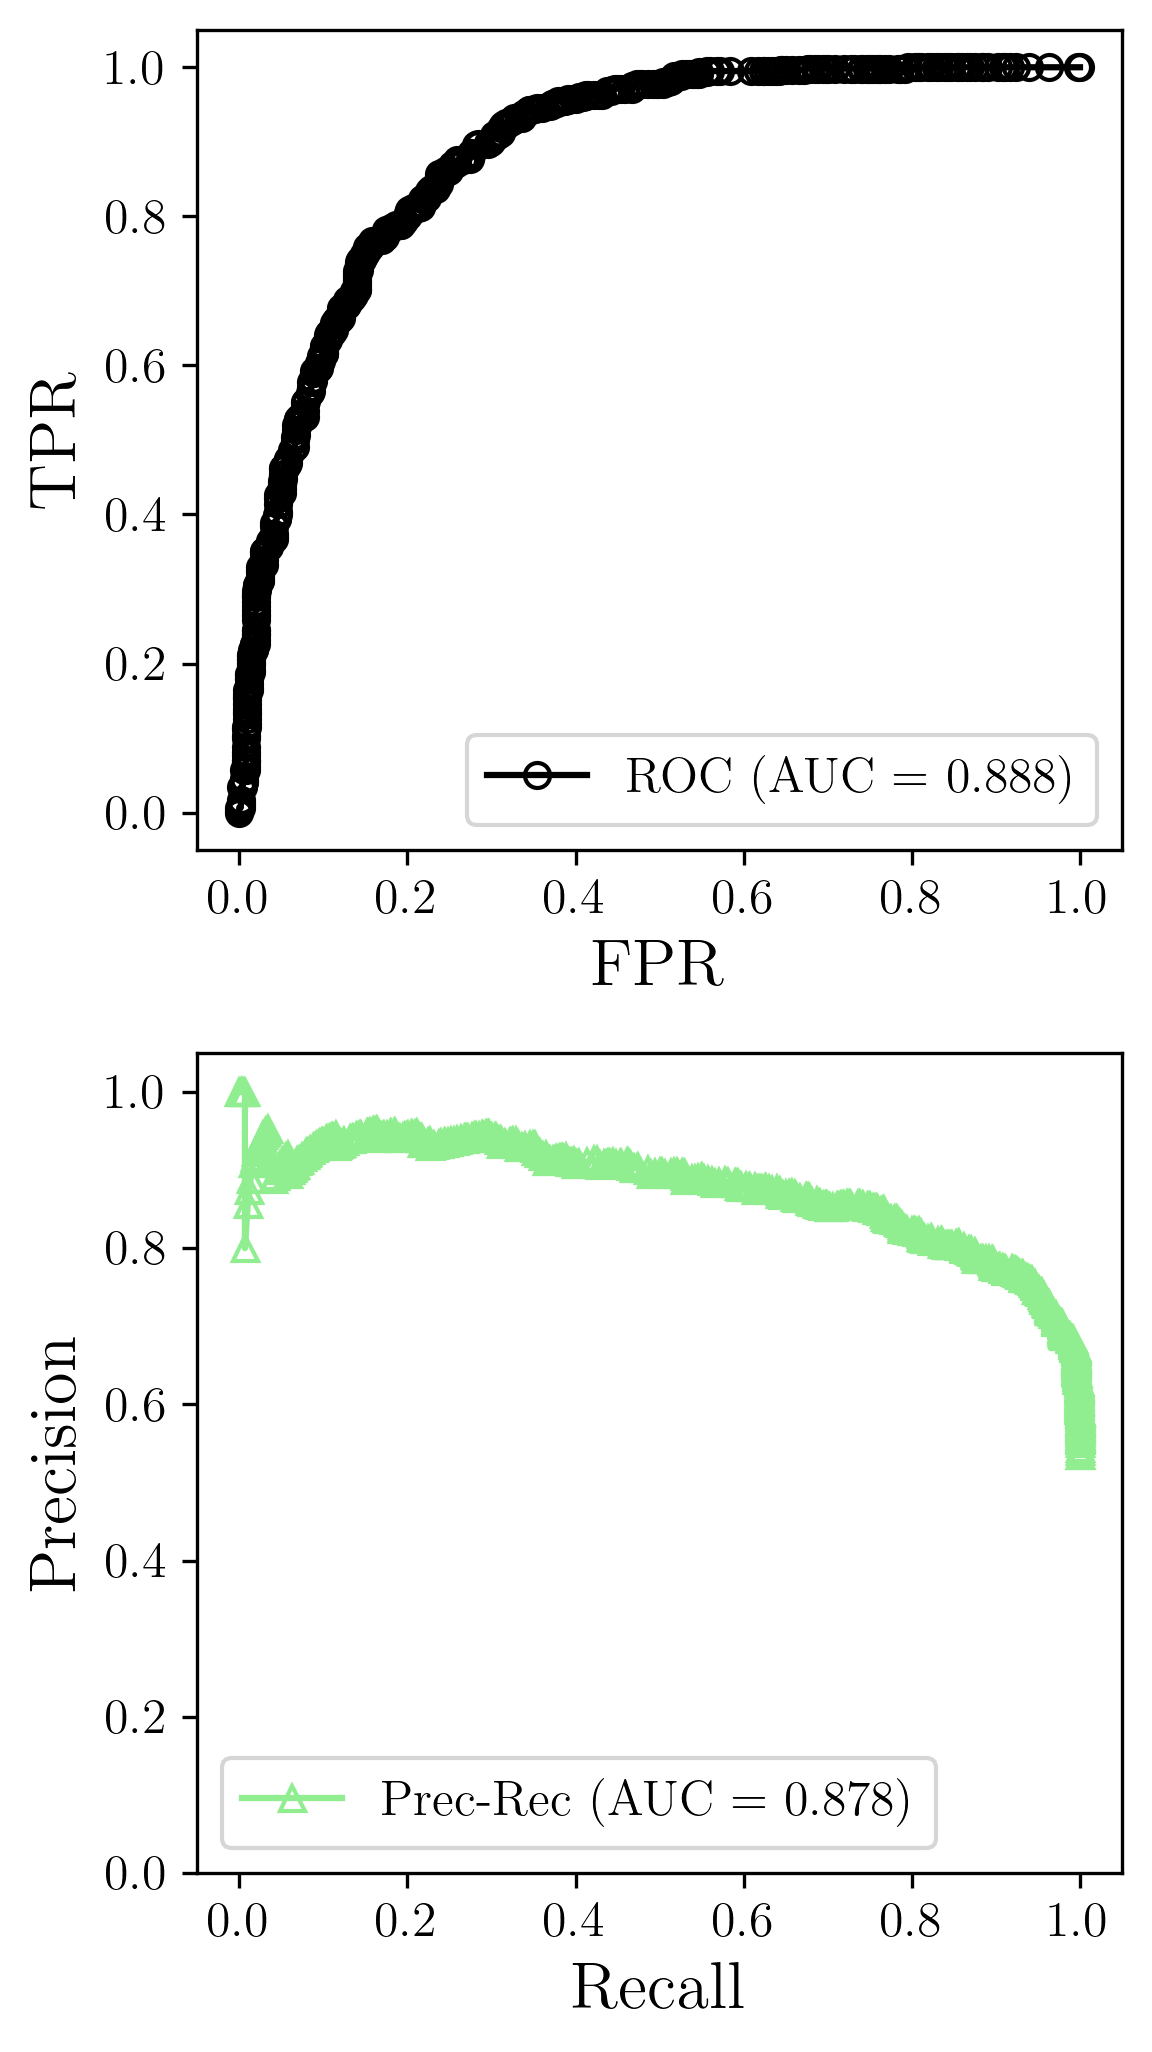

In [65]:
## Look at a few simple cases

pdb_name = "4u1c"

score_col = "Deeprank_gnn_esm"

roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

fig,ax = plt.subplots(2, 1,figsize = (4,7), dpi = 300)


## ROC Curve plot
ax[0].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0].set_xlabel("FPR", fontsize = fontsize)
ax[0].set_ylabel("TPR", fontsize = fontsize)

ax[1].set_xlabel("Recall", fontsize = fontsize)
ax[1].set_ylabel("Precision", fontsize = fontsize)

ax[1].set_ylim([0,1.05])

ax[0].legend()
ax[1].legend()

fig.tight_layout()

In [96]:
## Look at the average delta AUC in the precision-recall vs ROC for each scoring function!

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]


delta_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
        
        roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

        pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]
        
        delta_dict[score_col].append(pr_auc - roc_auc)
        



Avg |Delta| for ZRank2: 	 0.0150; 	 stdev:  0.0207
Avg |Delta| for ITScorePP: 	 0.0182; 	 stdev:  0.0251
Avg |Delta| for Rosetta: 	 0.0248; 	 stdev:  0.0157
Avg |Delta| for PyDock: 	 0.0191; 	 stdev:  0.0257
Avg |Delta| for VoroMQA: 	 0.0482; 	 stdev:  0.0385
Avg |Delta| for GNN-DOVE: 	 0.0931; 	 stdev:  0.0987
Avg |Delta| for Deeprank-GNN-ESM: 	 0.0274; 	 stdev:  0.0300


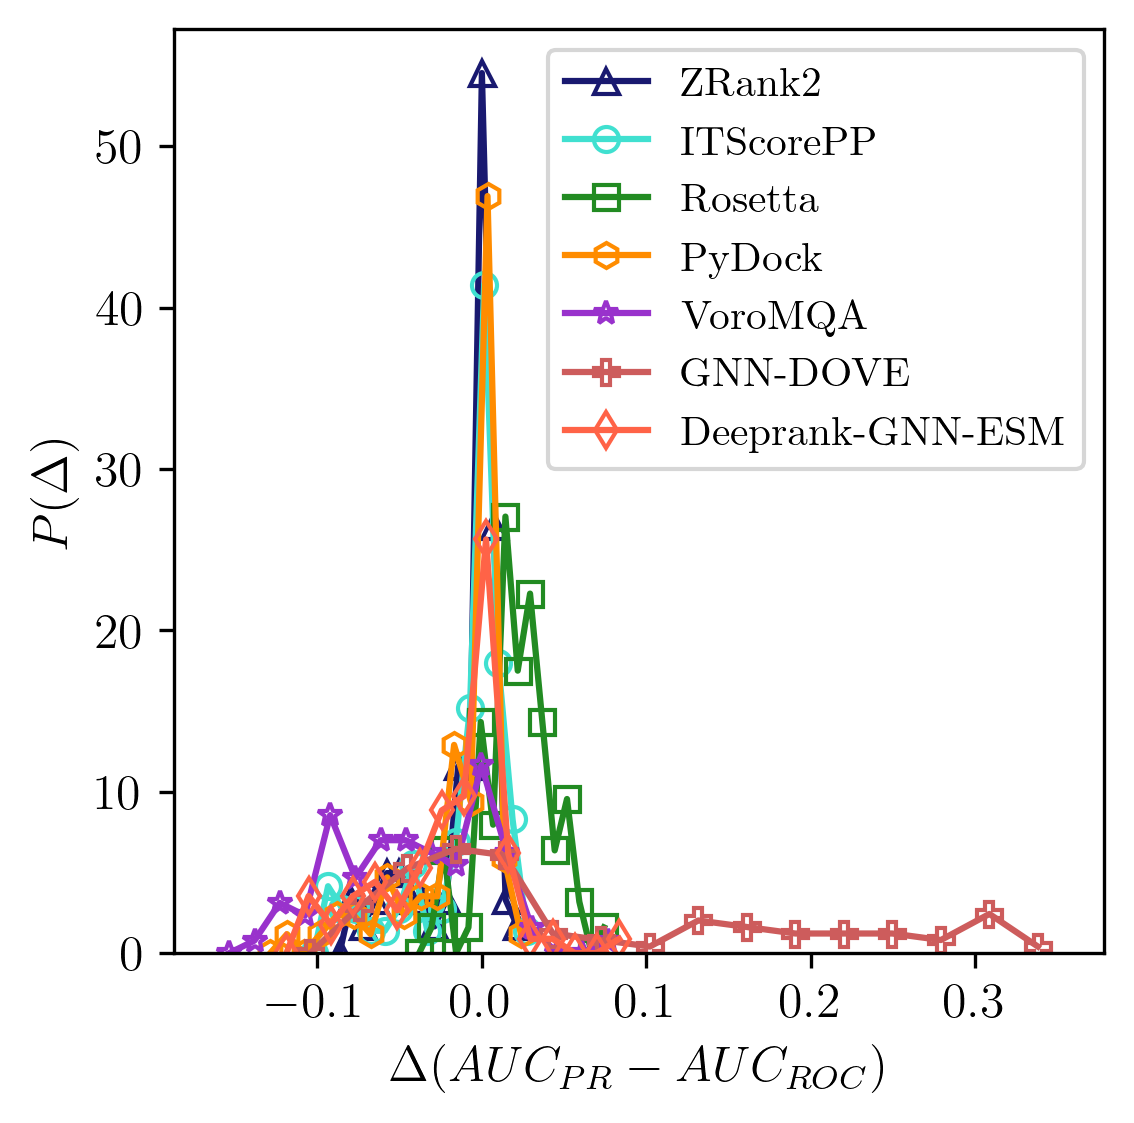

In [97]:
## Plot the deltas on the same plot

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

nbins = 15

for i,score_col in enumerate(score_list):
    
    x = create_prob_dist_identical_bins(delta_dict[score_col], fig, ax, color = colors[i],
                                        marker = markers[i], label = actual_names[i], n_bins = nbins)
    
    print(f"Avg |Delta| for {actual_names[i]}: \t{np.mean(np.abs(delta_dict[score_col])): 0.4f}; \t stdev: {np.std(np.abs(delta_dict[score_col])): 0.4f}")
    
ax.set_xlabel("$\Delta (AUC_{PR} - AUC_{ROC})$")
ax.set_ylabel("$P(\Delta)$")

ax.legend(fontsize = 10)

## Precision-recall vs AUC for exhaustively sampled data

In [90]:
def generate_all_roc_data_ex(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the ROC
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
                
            try:
            
                (fpr, tpr, thresh), temp_auc = get_indiv_ROC_curve(model_dict[pdb_name], col_name = score_col, dockq_cutoff = dockq_cutoff, factor = factor)

                temp_pdb_dict[score_col] = [temp_auc, fpr, tpr]
                
            except:
                
                print(pdb_name, score_col)
                temp_pdb_dict[score_col] = [0, -1, -1]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

def generate_all_precision_recall_curves_ex(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the precision-recall
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
                
            try:
            
                temp_prec, temp_recall = get_precision_recall_curve(model_dict[pdb_name], score_col = score_col, dockq_cutoff = dockq_cutoff, factor = factor)

                ## Getting the AUC
                sort_ind = np.argsort(temp_recall)
                sort_prec = temp_prec[sort_ind]
                sort_recall = temp_recall[sort_ind]
                temp_auc = integrate.trapz(x = sort_recall, y = sort_prec)

                temp_pdb_dict[score_col] = [temp_auc, temp_recall, temp_prec]
                
            except:
                print(pdb_name, score_col)
                temp_pdb_dict[score_col] = [0, -1, -1]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

In [91]:
## Get the precision_recall_data and ROC data

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

prec_recall_dict_ex = generate_all_precision_recall_curves_ex(pdb_list, exhaustive_score_dict, score_list)
roc_dict_ex = generate_all_roc_data_ex(pdb_list, exhaustive_score_dict, score_list)

/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/

5by8 ZRank
5by8 itscorepp
5by8 Rosetta
5by8 PyDock
5by8 VoroMQA
5by8 Dove_5
5by8 Deeprank_gnn_esm


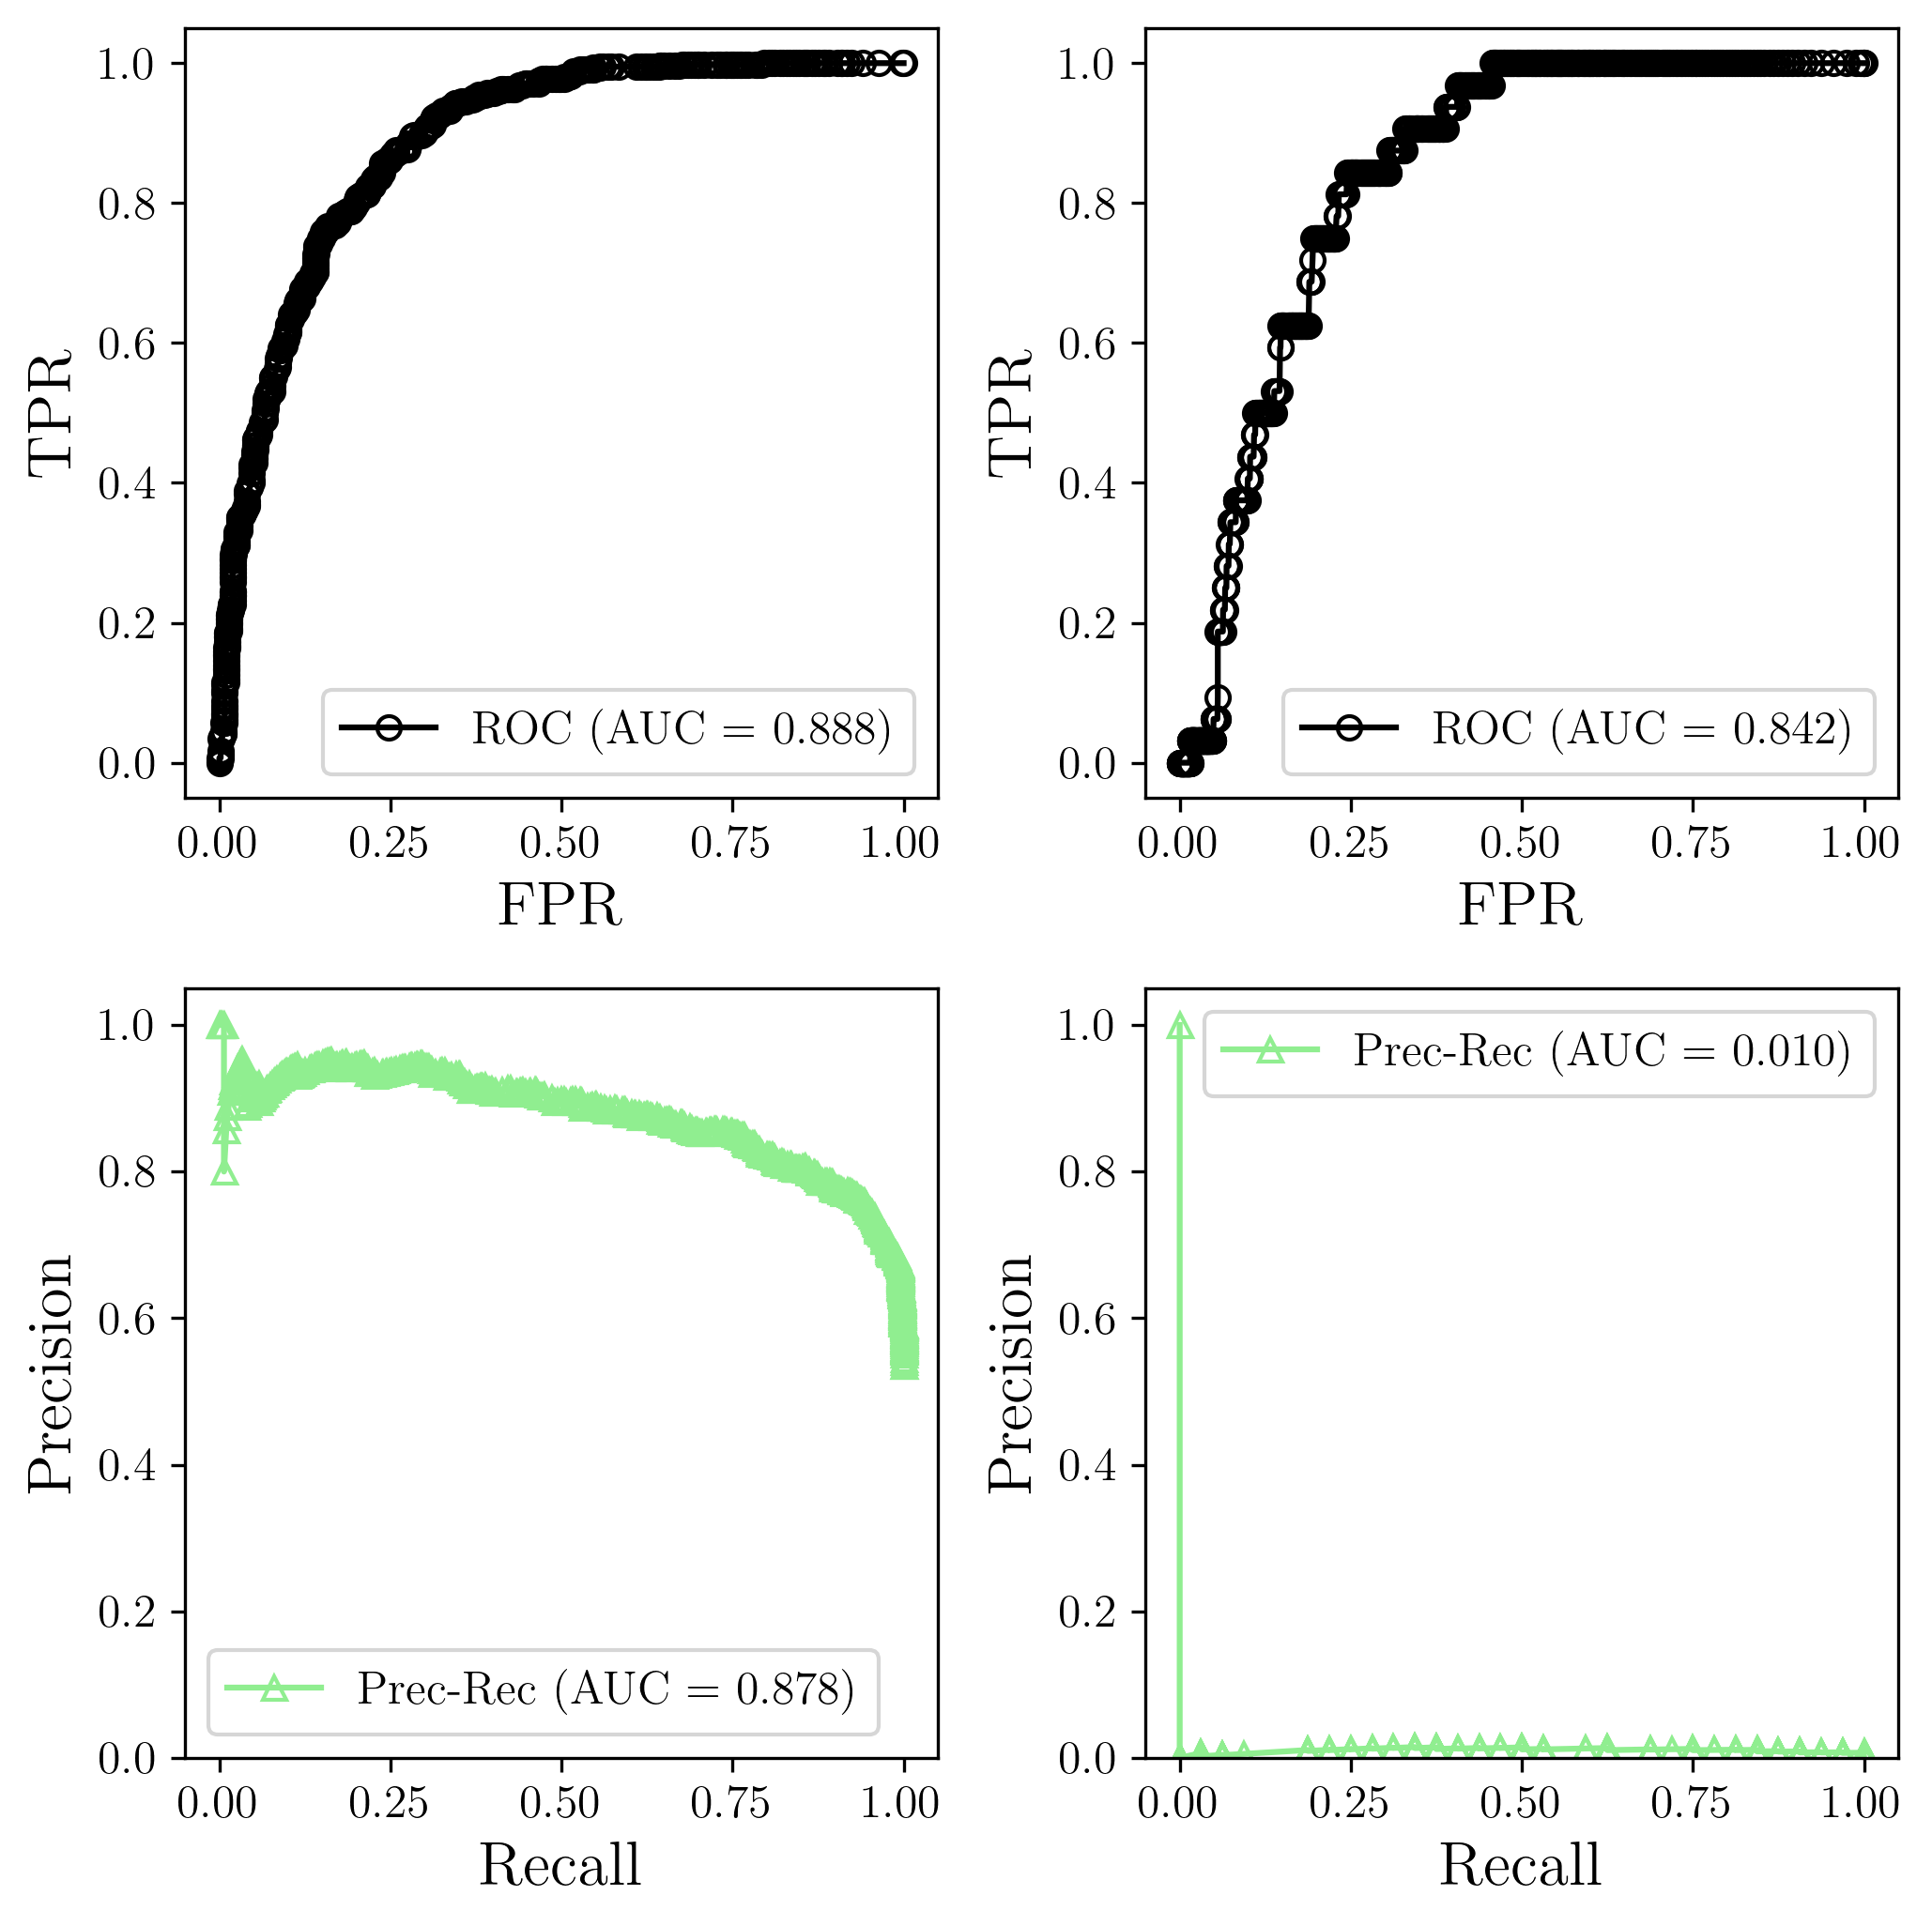

In [92]:
## Look at a few simple cases

pdb_name = "4u1c"

score_col = "Deeprank_gnn_esm"

## Uniform Data

roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

fig,ax = plt.subplots(2, 2,figsize = (7,7), dpi = 300)


## ROC Curve plot
ax[0,0].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1,0].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0,0].set_xlabel("FPR", fontsize = fontsize)
ax[0,0].set_ylabel("TPR", fontsize = fontsize)

ax[1,0].set_xlabel("Recall", fontsize = fontsize)
ax[1,0].set_ylabel("Precision", fontsize = fontsize)

ax[1,0].set_ylim([0,1.05])

ax[0,0].legend()
ax[1,0].legend()


## Exhaustive Data

roc_auc, roc_x, roc_y = roc_dict_ex[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]


## ROC Curve plot
ax[0,1].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1,1].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0, 1].set_xlabel("FPR", fontsize = fontsize)
ax[0, 1].set_ylabel("TPR", fontsize = fontsize)

ax[1,1].set_xlabel("Recall", fontsize = fontsize)
ax[1,1].set_ylabel("Precision", fontsize = fontsize)

ax[1,1].set_ylim([0,1.05])

ax[0,1].legend()
ax[1,1].legend()

fig.tight_layout()

In [98]:
## Look at the average delta AUC in the precision-recall vs ROC for each scoring function!

pdb_list = list(ss_corr_df["pdb"])

del pdb_list[pdb_list.index("5by8")]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]


delta_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
        
        roc_auc, roc_x, roc_y = roc_dict_ex[pdb_name][score_col]

        pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]
        
        delta_dict[score_col].append(pr_auc - roc_auc)
        



Avg |Delta| for ZRank2: 	 0.5764; 	 stdev:  0.2209
Avg |Delta| for ITScorePP: 	 0.5718; 	 stdev:  0.2035
Avg |Delta| for Rosetta: 	 0.5335; 	 stdev:  0.1383
Avg |Delta| for PyDock: 	 0.6035; 	 stdev:  0.2034
Avg |Delta| for VoroMQA: 	 0.6552; 	 stdev:  0.1721
Avg |Delta| for GNN-DOVE: 	 0.5714; 	 stdev:  0.2259
Avg |Delta| for Deeprank-GNN-ESM: 	 0.6366; 	 stdev:  0.1775


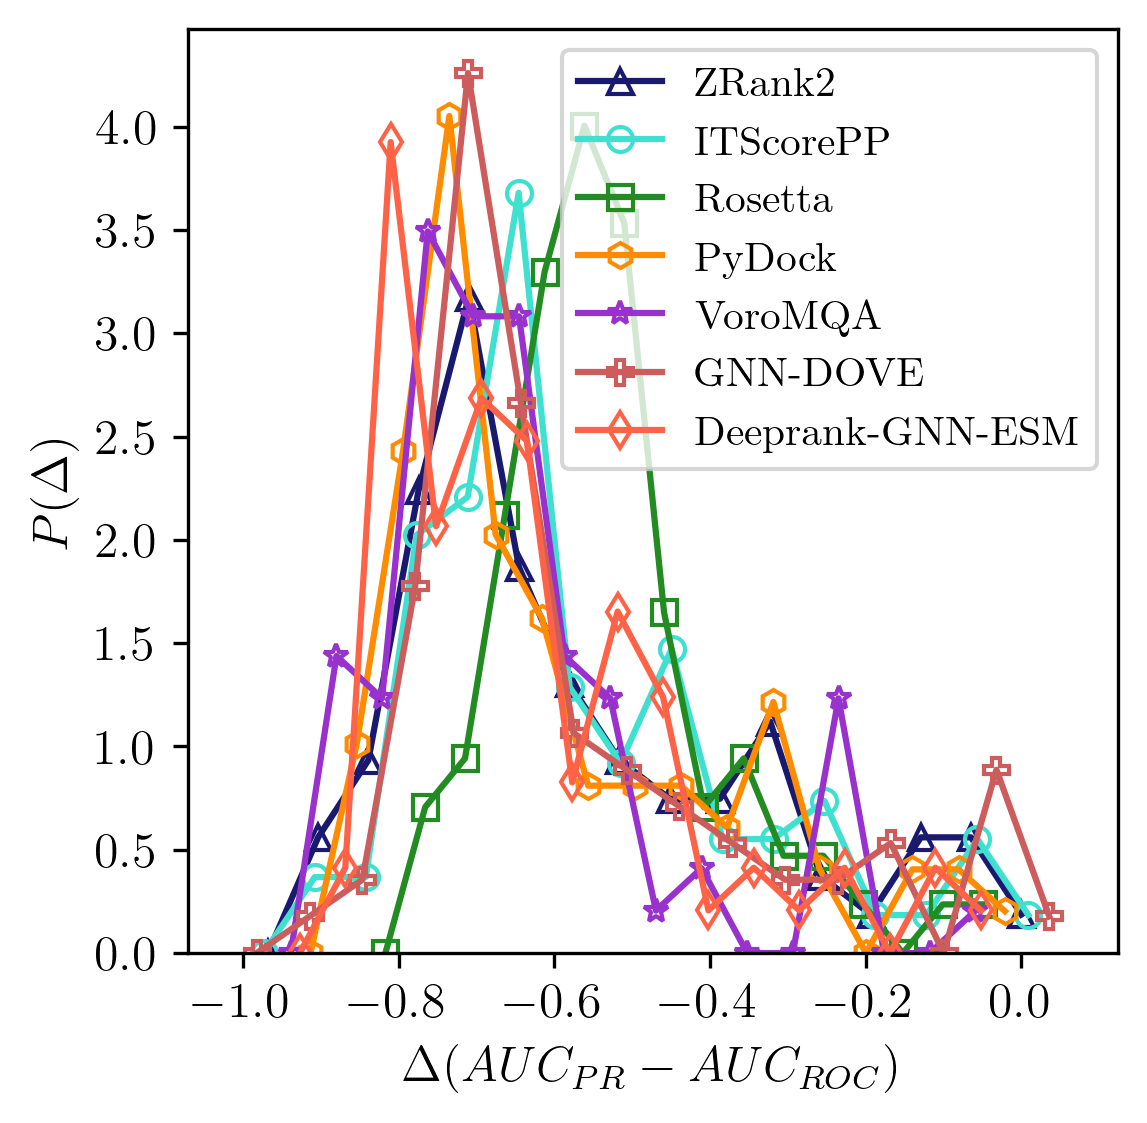

In [99]:
## Plot the deltas on the same plot

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

nbins = 15

for i,score_col in enumerate(score_list):
    
    x = create_prob_dist_identical_bins(delta_dict[score_col], fig, ax, color = colors[i],
                                        marker = markers[i], label = actual_names[i], n_bins = nbins)
    
    print(f"Avg |Delta| for {actual_names[i]}: \t{np.mean(np.abs(delta_dict[score_col])): 0.4f}; \t stdev: {np.std(np.abs(delta_dict[score_col])): 0.4f}")
    
ax.set_xlabel("$\Delta (AUC_{PR} - AUC_{ROC})$")
ax.set_ylabel("$P(\Delta)$")

ax.legend(fontsize = 10)

## Remaking the AUC vs Rho plot for figure 2D

In [100]:
exhaustive_corr_df

,Unnamed: 0,pdb,pearson_ialign_zrank,pearson_ialign_itscorepp,pearson_ialign_rosetta,pearson_ialign_pydock,pearson_ialign_voromqa,pearson_ialign_deeprank_gnn_esm,pearson_ialign_contact_45,pearson_ialign_interface_rsa,...,zrank_auc,itscorepp_auc,rosetta_auc,pydock_auc,voromqa_auc,deeprank_gnn_esm_auc,contact_45_auc,interface_rsa_auc,intertwined_auc,dove_5_auc
0,0,1acb,-0.235022,-0.189965,-0.224187,-0.332248,0.132492,0.439543,0.206233,0.102709,...,0.716174,0.684107,0.816975,0.811636,0.699729,0.864072,0.653464,0.585908,0.825284,0.357647
1,1,1ay7,-0.283463,-0.339345,-0.131687,-0.241674,0.052912,0.368353,0.306834,0.263358,...,0.864943,0.870491,0.671201,0.801053,0.655819,0.943321,0.843242,0.904700,0.709393,0.154745
2,2,1c3a,-0.434172,-0.444583,-0.345487,-0.448485,0.111670,0.363813,0.455205,0.309394,...,0.971536,0.978328,0.924882,0.984197,0.839953,0.970803,0.960197,0.973905,0.948383,0.797168
3,3,1euv,-0.476640,-0.318318,-0.111582,-0.429624,0.077033,0.466367,0.401006,0.193029,...,0.976856,0.920511,0.661241,0.976524,0.633339,0.888225,0.919675,0.898524,0.921013,0.129047
4,4,1f60,-0.300156,-0.358188,-0.210983,-0.229041,0.126909,0.264632,0.323695,0.270758,...,0.907513,0.936957,0.820535,0.868800,0.771818,0.880414,0.910756,0.930618,0.858322,0.379599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,6zbk,-0.093603,-0.126746,-0.216768,-0.061346,0.146762,0.322080,0.080919,0.077918,...,0.847640,0.862141,0.852699,0.769281,0.858396,0.934795,0.767173,0.857685,0.843441,0.229968
80,80,7bxh,-0.220195,-0.218398,-0.148078,-0.180128,0.132796,0.037562,0.192304,0.160255,...,0.950572,0.947291,0.781290,0.889811,0.858542,0.676064,0.926014,0.915741,0.914551,0.391537
81,81,7joe,-0.224471,-0.284138,-0.153980,-0.196861,0.108363,0.457476,0.223649,0.228223,...,0.799366,0.844311,0.742619,0.775914,0.716971,0.954143,0.779038,0.836390,0.901826,0.201902
82,82,7jxv,-0.174920,-0.147587,-0.150156,-0.300495,0.117415,0.310543,0.074170,0.044370,...,0.798157,0.781723,0.710167,0.883603,0.679882,0.900467,0.639616,0.634707,0.525978,0.259291


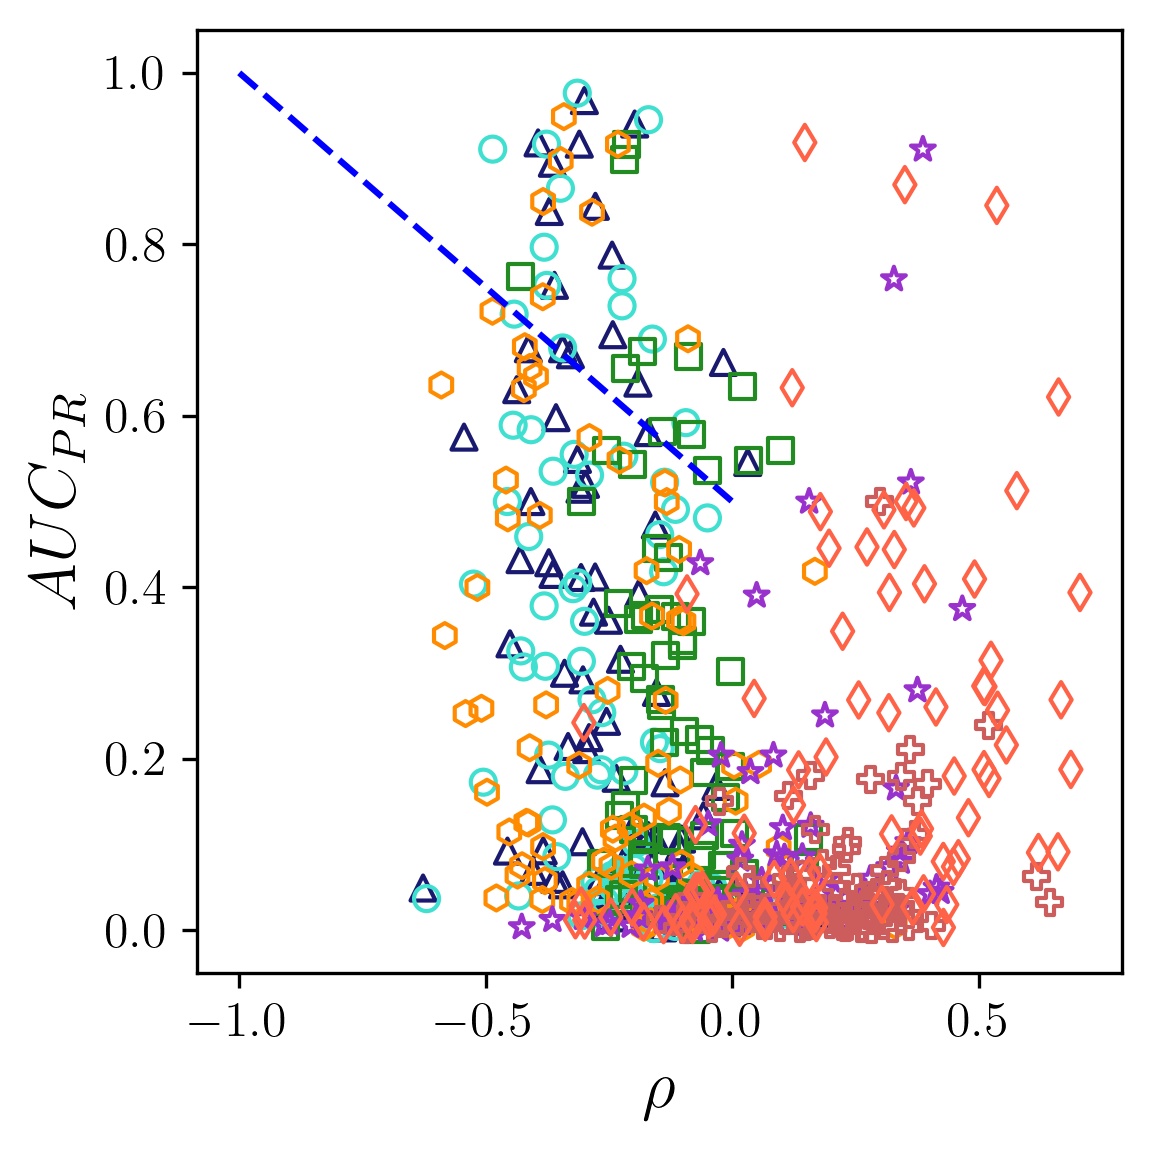

In [125]:
## Exhaustive data

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

pdb_list = list(ss_corr_df["pdb"])

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    x_data = exhaustive_corr_df[rho_col_name]
    
    ax.scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax.set_xlabel(r"$\rho$", fontsize = fontsize)
ax.set_ylabel("$AUC_{PR}$", fontsize = fontsize)

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax.plot(temp_x, temp_y, "b--", )

# fig.legend(loc = (0.73,0.25))

fig.tight_layout()

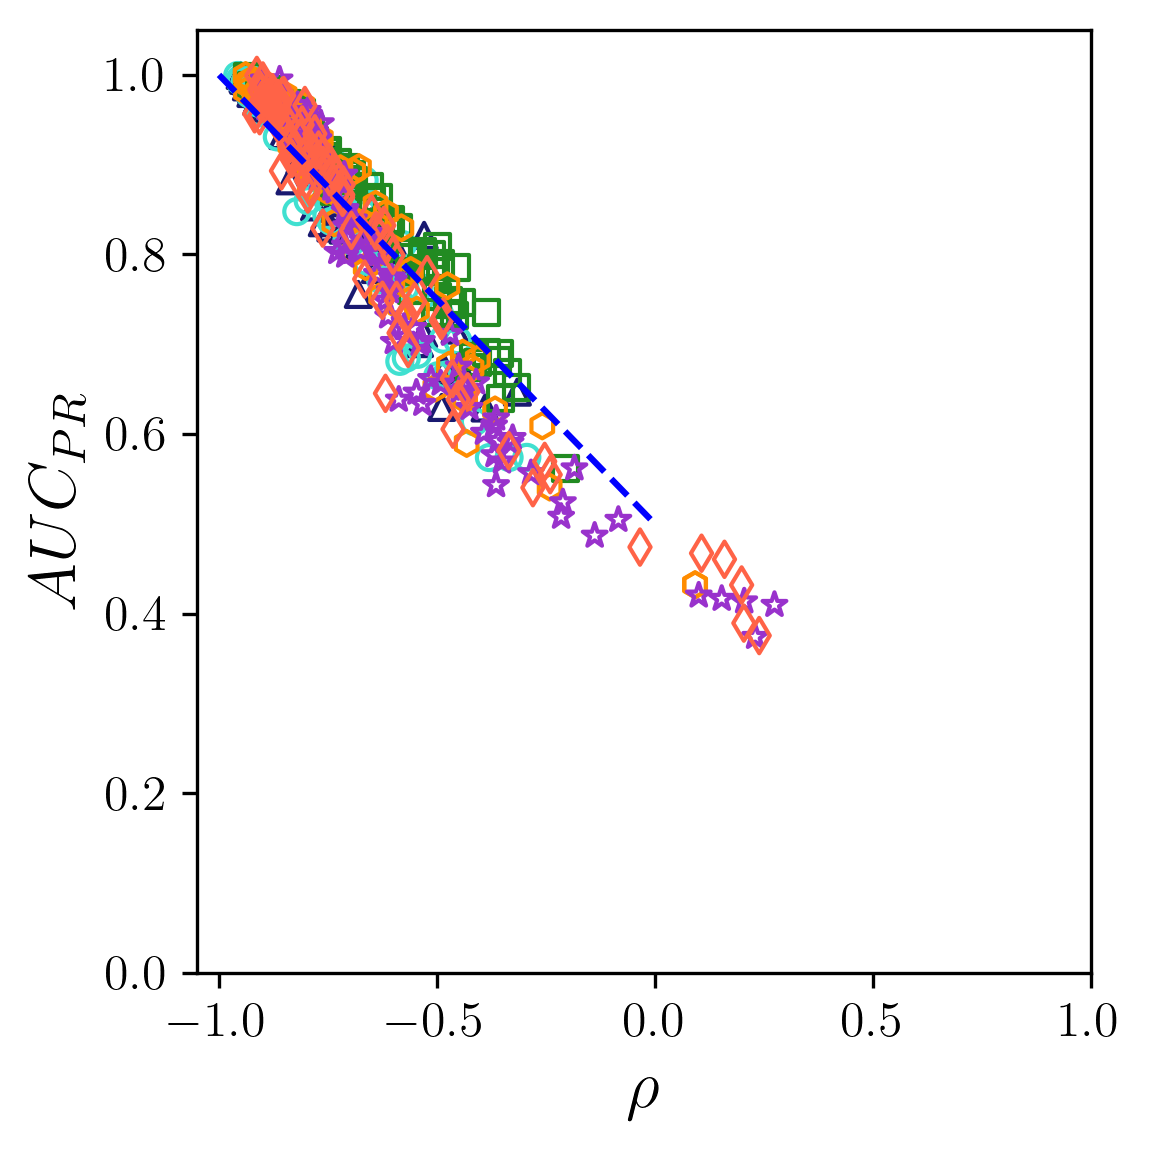

In [132]:
## Uniform Data

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

pdb_list = list(ss_corr_df["pdb"])

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    if score_col in "Dove_5":
        continue
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    if score_col in pos_factor_list:
        factor = -1
    else:
        factor = 1
    
    x_data = ss_corr_df[rho_col_name] * factor
    
    
    ax.scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax.set_xlabel(r"$\rho$", fontsize = fontsize)
ax.set_ylabel("$AUC_{PR}$", fontsize = fontsize)

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax.plot(temp_x, temp_y, "b--", )

ax.set_xlim([-1.05,1])
ax.set_ylim([0,1.05])

# fig.legend(loc = (0.73,0.25))

fig.tight_layout()

## Delta Plot

In [ ]:
## Create precision recall list in same order 

In [139]:
key_list = ["zrank_auc", "itscorepp_auc", "rosetta_auc", "pydock_auc", "voromqa_auc", "deeprank_gnn_esm_auc"]

pr_auc_list_un = {key: [] for key in key_list}
pr_auc_list_ex = {key: [] for key in key_list}

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Deeprank_gnn_esm"]

for pdb_name in pdb_list:
    
    for i,score_col in enumerate(score_list):
    
        pr_auc_list_un[key_list[i]].append(prec_recall_dict[pdb_name][score_col][0])
        pr_auc_list_ex[key_list[i]].append(prec_recall_dict_ex[pdb_name][score_col][0])

(-0.8, 1.0)

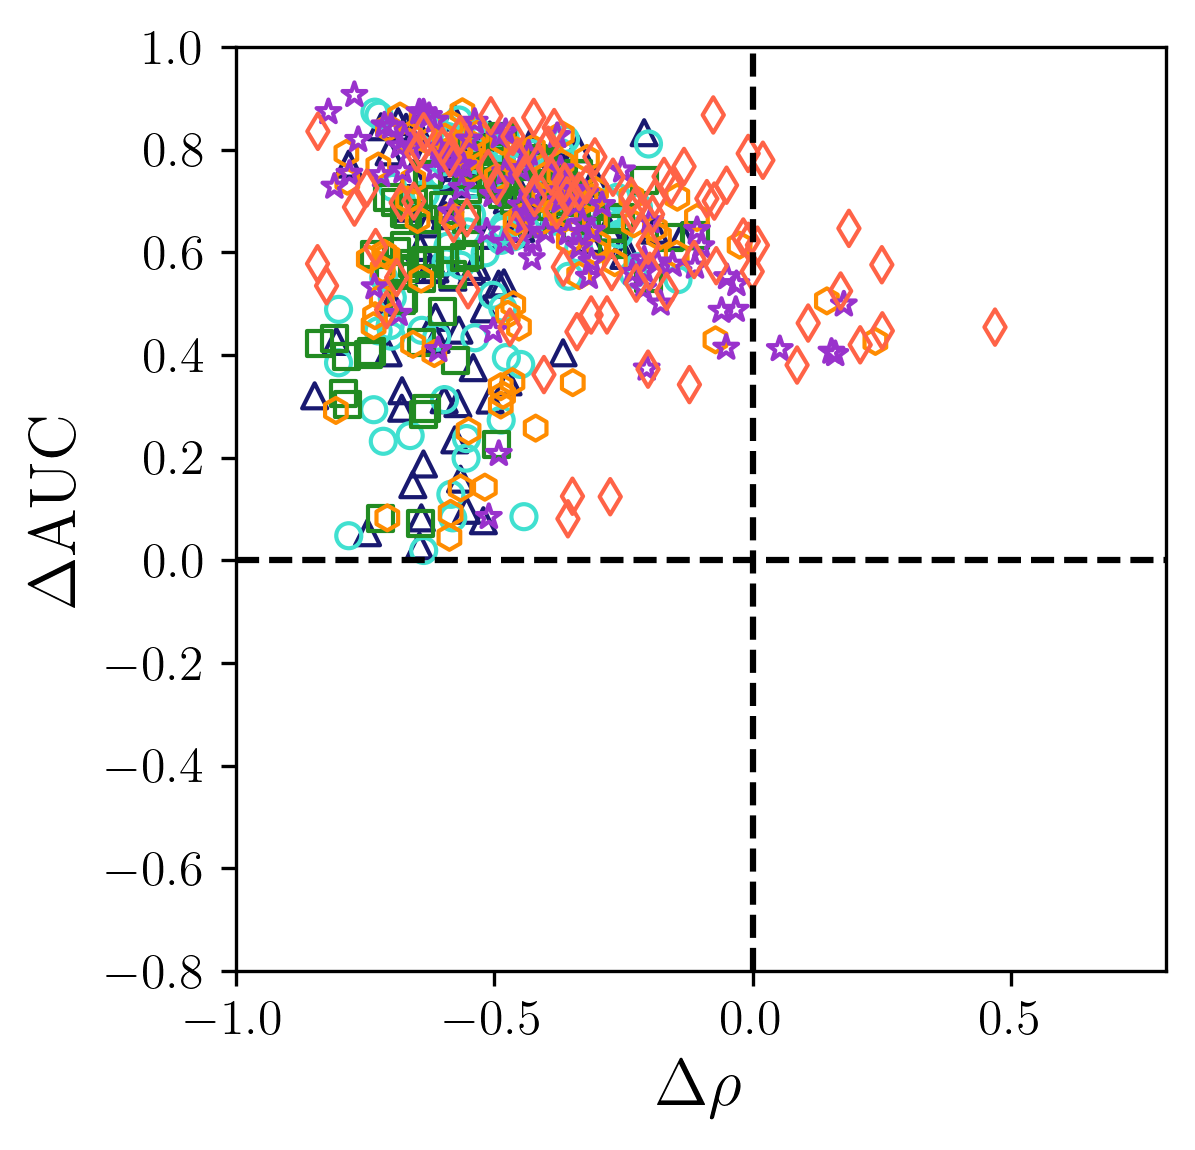

In [142]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "tomato"]

zrank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_zrank"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_zrank"]))*-1
zrank_auc_delta = np.array(pr_auc_list_un["zrank_auc"]) - np.array(pr_auc_list_ex["zrank_auc"])

hdock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_itscorepp"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_itscorepp"]))*-1
hdock_auc_delta = np.array(pr_auc_list_un["itscorepp_auc"]) - np.array(pr_auc_list_ex["itscorepp_auc"])

rosetta_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_rosetta"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_rosetta"]))*-1
rosetta_auc_delta = np.array(pr_auc_list_un["rosetta_auc"]) - np.array(pr_auc_list_ex["rosetta_auc"])

pydock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_pydock"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_pydock"]))*-1
pydock_auc_delta = np.array(pr_auc_list_un["pydock_auc"]) - np.array(pr_auc_list_ex["pydock_auc"])

voromqa_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_voromqa"])) *-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_voromqa"])) *-1
voromqa_auc_delta = np.array(pr_auc_list_un["voromqa_auc"]) - np.array(pr_auc_list_ex["voromqa_auc"])

deeprank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1 - np.abs(np.array(relaxed_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1
deeprank_auc_delta = np.array(pr_auc_list_un["deeprank_gnn_esm_auc"]) - np.array(pr_auc_list_ex["deeprank_gnn_esm_auc"])

ax2_1 = ax.scatter(zrank_spearman_delta,
           zrank_auc_delta,
           color = colors[0], marker = "^", label = "ZRank", facecolor = "None")
ax2_2 = ax.scatter(hdock_spearman_delta,
           hdock_auc_delta,
           color = colors[1], marker = "o", label = "ITScorePP", facecolor = "None")
ax2_3 = ax.scatter(rosetta_spearman_delta,
           rosetta_auc_delta,
           color = colors[2], marker = "s", label = "Rosetta", facecolor = "None")
ax2_4 = ax.scatter(pydock_spearman_delta,
           pydock_auc_delta,
           color = colors[3], marker = "h", label = "PyDock", facecolor = "None")
ax2_5 = ax.scatter(voromqa_spearman_delta,
           voromqa_auc_delta,
           color = colors[4], marker = "*", label = "VoroMQA", facecolor = "None")
ax2_6 = ax.scatter(deeprank_spearman_delta,
           deeprank_auc_delta,
           color = colors[5], marker = "d", label = "Deeprank-GNN", facecolor = "None")

ax.set_ylabel("$\Delta$AUC", fontsize = 16)
ax.set_xlabel(r"$\Delta\rho$", fontsize = 16)

## Create vertical and horizontal dotted lines

x_vert = [0,0]
y_vert = [-0.8, 1.0]
ax.plot(x_vert, y_vert, color = "black", linestyle = "--")

x_horiz = [-1, 0.8]
y_horiz = [0,0]
ax.plot(x_horiz, y_horiz, color = "black", linestyle = "--")

ax.set_xlim([-1, 0.8])
ax.set_ylim([-0.8, 1.0])

# Physical Feature Description

- Do cross-correlations of the features
- Make distributions of the features relative to other PPI datasets
- Justify why we use the features

In [134]:
ss_corr_df

,Unnamed: 0,pdb,pearson_ialign_zrank,pearson_ialign_hdock,pearson_ialign_rosetta,pearson_ialign_pydock,pearson_ialign_voromqa,pearson_ialign_voromqa_js,pearson_ialign_dove_5,pearson_ialign_intertwined,...,contact_43_auc,contact_44_auc,contact_45_auc,interface_rsa_auc,itscorepp_auc,flatness_p3,resolution,complex_sasa,monomer_sasa,relative_interface_sasa
0,0,1acb,-0.717506,-0.572495,-0.818415,-0.742908,0.774556,0.848402,0.564269,-0.550571,...,0.762547,0.764547,0.764325,0.644104,0.772073,0.975254,2.00,13210.040041,14768.793567,0.105544
1,1,1ay7,-0.804331,-0.644121,-0.720965,-0.518193,0.524763,0.730545,0.788741,-0.439244,...,0.856978,0.855582,0.855477,0.866396,0.852197,0.986755,1.70,9183.406105,10429.633791,0.119489
2,2,1c3a,-0.965753,-0.961120,-0.938805,-0.954437,0.768060,0.969857,-0.877749,-0.791142,...,0.984526,0.984476,0.985112,0.987780,0.991357,0.928116,2.50,13225.609142,16856.480544,0.215399
3,3,1euv,-0.903749,-0.810849,-0.561124,-0.861152,0.159493,0.793307,0.497068,-0.812000,...,0.964044,0.962955,0.962283,0.955443,0.966066,0.977500,1.60,14257.751994,16597.227354,0.140956
4,4,1f60,-0.934282,-0.954465,-0.874791,-0.824968,0.788822,0.839942,-0.579722,-0.814475,...,0.961521,0.961780,0.961856,0.964506,0.971226,0.968571,1.67,22759.106785,26255.747109,0.133176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,6zbk,-0.781797,-0.774058,-0.835361,-0.678408,0.624669,0.850289,0.749478,-0.432070,...,0.870750,0.869815,0.870923,0.903562,0.925137,0.988550,1.49,10502.811829,12380.058724,0.151635
80,80,7bxh,-0.804953,-0.820440,-0.814243,-0.720781,0.732772,0.929094,-0.467024,-0.319278,...,0.934254,0.934713,0.933303,0.882509,0.937586,0.977949,2.70,24004.295239,26437.741182,0.092044
81,81,7joe,-0.777183,-0.849470,-0.664958,-0.580647,0.694228,0.888198,0.623389,-0.771127,...,0.867603,0.869121,0.872491,0.871404,0.915791,0.972420,2.60,16411.454745,18374.501339,0.106835
82,82,7jxv,-0.619194,-0.622669,-0.477439,-0.504229,0.413785,0.575321,0.558159,0.088424,...,0.685357,0.688350,0.691165,0.722158,0.829122,0.994932,2.35,16126.311027,17441.072942,0.075383


Pearson Corrlation between the two variables: (-0.7615935056499921, 4.0784282164415304e-17)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=-0.8356181026627518, pvalue=4.837082324068372e-23)


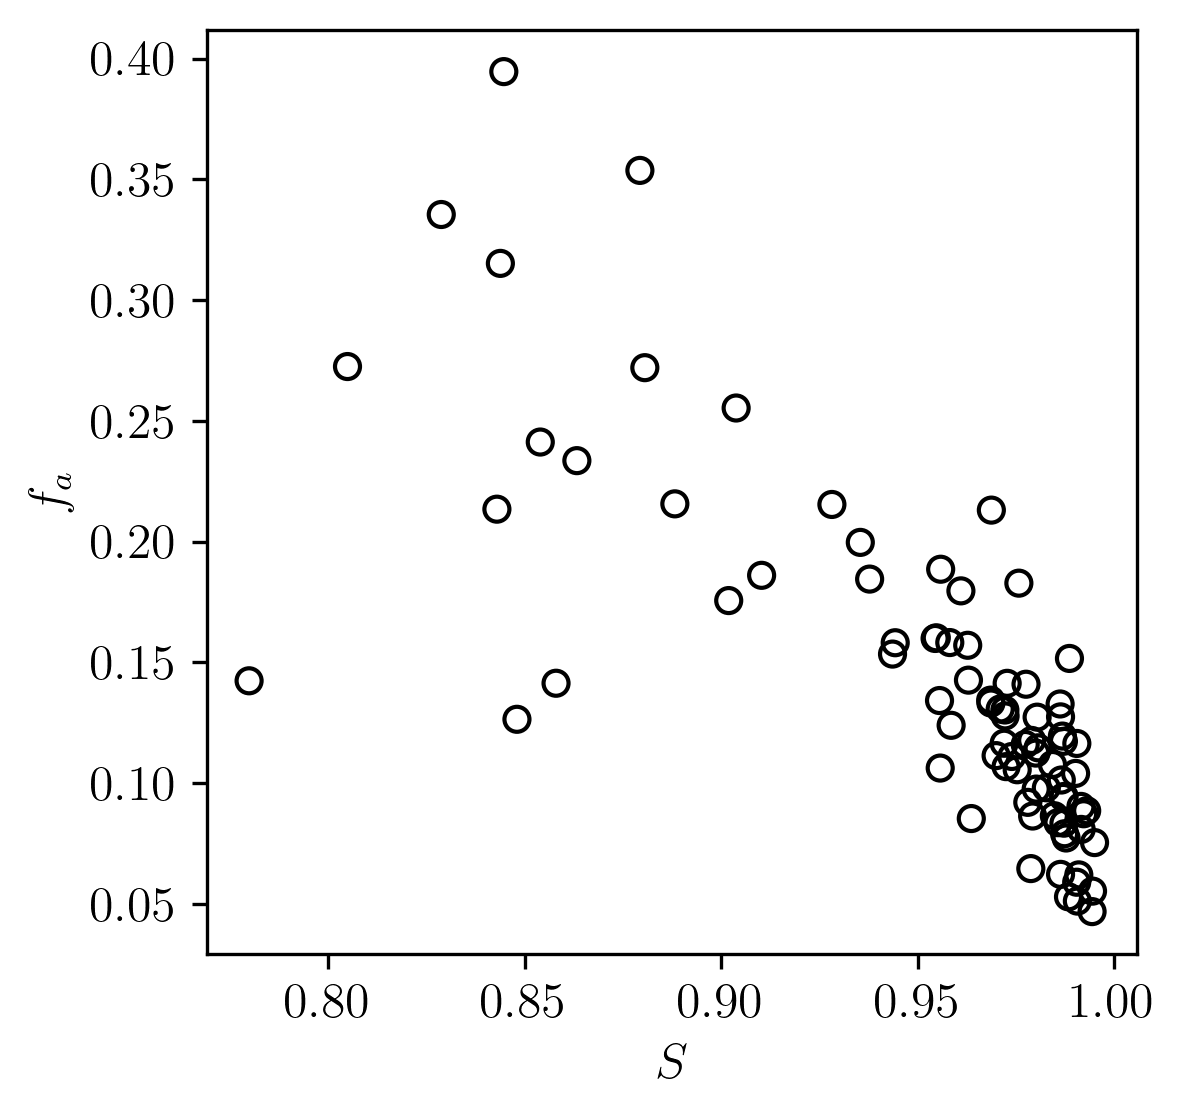

In [137]:
## Just look at it all for the targets

fig, ax = plt.subplots(1,1, figsize = (4, 4), dpi = 300)


S = ss_corr_df["flatness_p3"]
fa = ss_corr_df["relative_interface_sasa"]

ax.scatter(S, fa, color = "black", marker = "o", facecolor = "None")

ax.set_xlabel("$S$")
ax.set_ylabel("$f_a$")

print(f"Pearson Corrlation between the two variables: {pearsonr(S, fa)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(S, fa)}")